# Solution Part:
* Data Understanding
* Data Exploration
* Data Cleaning
* Data Preparation/Feature Engineering
* Model Building
* Model Evaluation

In [83]:
#Import all the libraries
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import (
    r2_score,
    mean_squared_error,
    mean_absolute_error,
    mean_absolute_percentage_error
)

In [84]:
import warnings
warnings.filterwarnings('ignore')

In [85]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [86]:
pd.set_option('display.max_rows', None)

In [87]:
#Read the dataset
cars = pd.read_csv('NAAA.csv', encoding='latin1')
cars_test = pd.read_excel('OH VINs w. Zips.xlsx')
cars_test_original = cars_test.copy()

In [88]:
cars_test['Location'] = 'OHIO'

In [89]:
cars.count()

gross_sale_price    1048575
mileage             1048575
model_year          1048575
make                1048575
model               1048575
Segment             1048575
dtype: int64

In [90]:
cars.isnull().sum()

gross_sale_price    0
mileage             0
model_year          0
make                0
model               0
Segment             0
dtype: int64

In [91]:
cars.head()

,gross_sale_price,mileage,model_year,make,model,Segment
0,24000,15200,2022,Subaru,WRX,Compact Car
1,10305,198580,2015,Chevrolet,Tahoe,Full-Size Crossover/SUV
2,8000,104198,2013,Audi,A4,Near Luxury Car
3,21000,58131,2020,Buick,Enclave,Mid-Size Crossover/SUV
4,40100,54412,2021,Chevrolet,Silverado 2500,Full-Size Pickup


Data Exploration

In [92]:
cars_test = cars_test.drop(['VIN','Auction lights - Green','Auction lights - Red','Zip','Transport Operable','Transport Inop','Representation','Sold Date','Operable','Location','Vehicle Grade (Approved CR)'], axis=1)
cars = cars.drop(['Segment'], axis = 1)

In [93]:
# Step 1: Rename the columns
cars_test = cars_test.rename(columns={
    'Year': 'model_year',
    'Make': 'make',
    'Model': 'model',
    'Mileage': 'mileage',
    'Operable': 'drivable',
})

In [94]:
def feature_engineering(df):
    # Fill missing model_year if any (optional)
    df["model_year"] = df["model_year"].fillna(df["model_year"].median())
    df["model_year"] = df["model_year"].astype(int)

    # Vehicle age
    df["vehicle_age"] = 2025 - df["model_year"]

    # Avoid div by zero
    df["vehicle_age"] = df["vehicle_age"].replace(0, 0.5)

    # Encode make
    df["make_code"] = df["make"].astype("category").cat.codes

    # Mileage * Age interaction
    df["mileage_age"] = df["mileage"] * df["vehicle_age"]


    # Buckets
    df["mileage_bucket"] = pd.cut(df["mileage"], bins=[0,50000,100000,150000,200000,300000], labels=False)
    df["age_bucket"] = pd.cut(df["vehicle_age"], bins=[0,3,5,8,12,20], labels=False)

    return df

In [95]:
cars = feature_engineering(cars)
cars_test = feature_engineering(cars_test)

In [96]:
cars_test.head()

,model_year,make,model,mileage,gross_sale_price,vehicle_age,make_code,mileage_age,mileage_bucket,age_bucket
0,2013,CHEVROLET,EQUINOX,114069,3600.000000,12,6,1368828,2.0,3
1,2013,ACURA,ILX,92052,13271.428571,12,0,1104624,1.0,3
2,2015,JEEP,WRANG UNLTD,98082,13000.000000,10,17,980820,1.0,3
3,2015,JEEP,COMPASS 4X4 4C,105313,9800.000000,10,17,1053130,2.0,3
4,2016,JEEP,CHEROKEE FWD 4C,118073,5000.000000,9,17,1062657,2.0,3


In [97]:
cars.head()

,gross_sale_price,mileage,model_year,make,model,vehicle_age,make_code,mileage_age,mileage_bucket,age_bucket
0,24000,15200,2022,Subaru,WRX,3.0,57,45600.0,0.0,0.0
1,10305,198580,2015,Chevrolet,Tahoe,10.0,8,1985800.0,3.0,3.0
2,8000,104198,2013,Audi,A4,12.0,3,1250376.0,2.0,3.0
3,21000,58131,2020,Buick,Enclave,5.0,6,290655.0,1.0,1.0
4,40100,54412,2021,Chevrolet,Silverado 2500,4.0,8,217648.0,1.0,1.0


In [98]:
cars_numeric = cars.select_dtypes(include=['float64','int64'])

In [99]:
cars_numeric.corr()

,gross_sale_price,mileage,model_year,vehicle_age,mileage_age,mileage_bucket,age_bucket
gross_sale_price,1.000000,-0.597979,0.600490,-0.600490,-0.540208,-0.596688,-0.654343
mileage,-0.597979,1.000000,-0.676344,0.676344,0.881430,0.967536,0.715211
model_year,0.600490,-0.676344,1.000000,-1.000000,-0.856027,-0.674673,-0.942744
vehicle_age,-0.600490,0.676344,-1.000000,1.000000,0.856027,0.674673,0.942744
mileage_age,-0.540208,0.881430,-0.856027,0.856027,1.000000,0.851930,0.789258
mileage_bucket,-0.596688,0.967536,-0.674673,0.674673,0.851930,1.000000,0.714039
age_bucket,-0.654343,0.715211,-0.942744,0.942744,0.789258,0.714039,1.000000


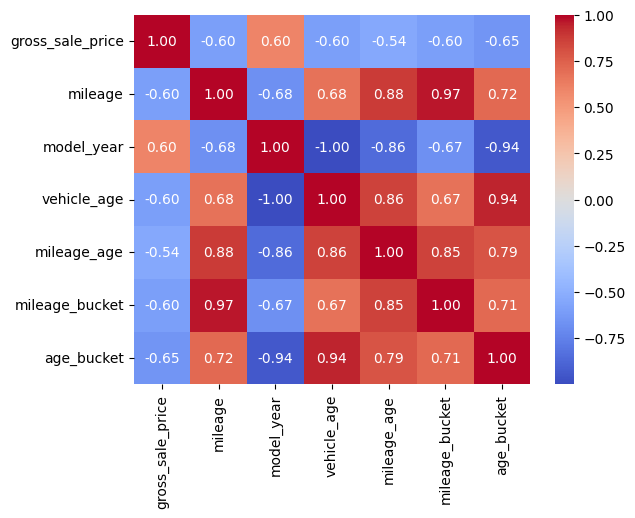

In [100]:
sns.heatmap(cars_numeric.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.show()

In [19]:
#Correlation plot
cor = cars_numeric.corr()
cor

,gross_sale_price,mileage,model_year,vehicle_age,mileage_age,mileage_bucket,age_bucket,make_avg_price
gross_sale_price,1.000000,-0.597979,0.600490,-0.600490,-0.540208,-0.596688,-0.654343,0.417296
mileage,-0.597979,1.000000,-0.676344,0.676344,0.881430,0.967536,0.715211,-0.075561
model_year,0.600490,-0.676344,1.000000,-1.000000,-0.856027,-0.674673,-0.942744,0.062859
vehicle_age,-0.600490,0.676344,-1.000000,1.000000,0.856027,0.674673,0.942744,-0.062859
mileage_age,-0.540208,0.881430,-0.856027,0.856027,1.000000,0.851930,0.789258,-0.063252
mileage_bucket,-0.596688,0.967536,-0.674673,0.674673,0.851930,1.000000,0.714039,-0.079898
age_bucket,-0.654343,0.715211,-0.942744,0.942744,0.789258,0.714039,1.000000,-0.065786
make_avg_price,0.417296,-0.075561,0.062859,-0.062859,-0.063252,-0.079898,-0.065786,1.000000


In [20]:
cars.isnull().sum()

gross_sale_price        0
mileage                 0
model_year              0
make                    0
model                   0
vehicle_age             0
make_code               0
mileage_age             0
mileage_bucket       5622
age_bucket          30693
make_avg_price          0
dtype: int64

Data Preparation

In [21]:
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute   import SimpleImputer
from sklearn.metrics import r2_score, mean_absolute_error

In [22]:
cars.head()

,gross_sale_price,mileage,model_year,make,model,vehicle_age,make_code,mileage_age,mileage_bucket,age_bucket,make_avg_price
0,24000,15200,2022,Subaru,WRX,3.0,57,45600.0,0.0,0.0,11180.485563
1,10305,198580,2015,Chevrolet,Tahoe,10.0,8,1985800.0,3.0,3.0,12913.734609
2,8000,104198,2013,Audi,A4,12.0,3,1250376.0,2.0,3.0,15991.697955
3,21000,58131,2020,Buick,Enclave,5.0,6,290655.0,1.0,1.0,8948.631344
4,40100,54412,2021,Chevrolet,Silverado 2500,4.0,8,217648.0,1.0,1.0,12913.734609


In [ ]:
# remove engine from your list of categoricals...
categorical_feats = [
    'make','model'
]

# …and add it into numeric_feats
numeric_feats = [
    'mileage','model_year','vehicle_age','make_code','mileage_age','mileage_bucket','age_bucket'
]

In [24]:
X_external = cars_test[numeric_feats + categorical_feats]

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats

In [26]:
num_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scale',   StandardScaler())
])

cat_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='Unknown', add_indicator=True)),
    ('ohe',      OneHotEncoder(handle_unknown='ignore', sparse_output=True))
])

preprocessor = ColumnTransformer([
    ('num', num_pipe, numeric_feats),
    ('cat', cat_pipe, categorical_feats),
], remainder='drop', sparse_threshold=1.0)

In [27]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

In [28]:
X = cars[numeric_feats + categorical_feats]
y = cars['gross_sale_price']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.01, random_state=42
)

In [29]:
# 4. Helper to build a full pipeline + extract coef names
def make_model_pipeline(model, poly=False):
    steps = []
    if poly:
        # expand numeric features to polynomial degree 2
        steps.append(('poly', PolynomialFeatures(degree=2, include_bias=False)))
    steps.append(('preproc', preprocessor))
    steps.append(('reg', model))
    return Pipeline(steps)

def get_feature_names(pipeline):
    """
    After fitting, get the transformed feature names in order, so you can map back to coefficients.
    Requires sklearn ≥ 1.0 for ColumnTransformer.get_feature_names_out.
    """
    # name from the 'preproc' step
    feat_names = pipeline.named_steps['preproc'].get_feature_names_out()
    if 'poly' in pipeline.named_steps:
        # if polynomial, get names from poly step
        feat_names = pipeline.named_steps['poly'].get_feature_names_out(feat_names)
    return feat_names

In [30]:
# Linear Regression

lin_pipe = make_model_pipeline(LinearRegression())
lin_pipe.fit(X_train, y_train)
lin_preds = lin_pipe.predict(X_test)

lin_r2 = r2_score(y_test, lin_preds)
lin_mae = mean_absolute_error(y_test, lin_preds)
lin_mse = mean_squared_error(y_test, lin_preds)
lin_rmse = np.sqrt(lin_mse)
lin_mape = mean_absolute_percentage_error(y_test, lin_preds)

lin_feat_names = get_feature_names(lin_pipe)
lin_coefs = lin_pipe.named_steps['reg'].coef_
lin_coef_df = pd.DataFrame({'feature': lin_feat_names, 'coef': lin_coefs}).sort_values(by='coef', key=lambda x: x.abs(), ascending=False)

In [31]:
#Lasso Regression (α=0.5)
lasso_pipe = make_model_pipeline(Lasso(alpha=0.5, max_iter=10_000))
lasso_pipe.fit(X_train, y_train)
lasso_preds = lasso_pipe.predict(X_test)

lasso_r2 = r2_score(y_test, lasso_preds)
lasso_mae = mean_absolute_error(y_test, lasso_preds)
lasso_mse = mean_squared_error(y_test, lasso_preds)
lasso_rmse = np.sqrt(lasso_mse)
lasso_mape = mean_absolute_percentage_error(y_test, lasso_preds)

lasso_feat_names = get_feature_names(lasso_pipe)
lasso_coefs = lasso_pipe.named_steps['reg'].coef_
lasso_coef_df = pd.DataFrame({'feature': lasso_feat_names, 'coef': lasso_coefs}).sort_values(by='coef', key=lambda x: x.abs(), ascending=False)

In [32]:
# Ridge Regression (α=0.5)
ridge_pipe = make_model_pipeline(Ridge(alpha=0.5))
ridge_pipe.fit(X_train, y_train)
ridge_preds = ridge_pipe.predict(X_test)

ridge_r2 = r2_score(y_test, ridge_preds)
ridge_mae = mean_absolute_error(y_test, ridge_preds)
ridge_mse = mean_squared_error(y_test, ridge_preds)
ridge_rmse = np.sqrt(ridge_mse)
ridge_mape = mean_absolute_percentage_error(y_test, ridge_preds)

ridge_feat_names = get_feature_names(ridge_pipe)
ridge_coefs = ridge_pipe.named_steps['reg'].coef_
ridge_coef_df = pd.DataFrame({'feature': ridge_feat_names, 'coef': ridge_coefs}).sort_values(by='coef', key=lambda x: x.abs(), ascending=False)

In [33]:
# For polynomial model only
poly_num_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ('scale', StandardScaler())
])

cat_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='Unknown', add_indicator=True)),
    ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=True))
])

poly_preprocessor = ColumnTransformer([
    ('num', poly_num_pipe, numeric_feats),
    ('cat', cat_pipe, categorical_feats),
], remainder='drop', sparse_threshold=1.0)

poly_pipe = Pipeline([
    ('preproc', poly_preprocessor),
    ('reg', LinearRegression())
])

poly_pipe.fit(X_train, y_train)
poly_preds = poly_pipe.predict(X_test)

poly_r2 = r2_score(y_test, poly_preds)
poly_mae = mean_absolute_error(y_test, poly_preds)
poly_mse = mean_squared_error(y_test, poly_preds)
poly_rmse = np.sqrt(poly_mse)
poly_mape = mean_absolute_percentage_error(y_test, poly_preds)

poly_feat_names = poly_pipe.named_steps['preproc'].get_feature_names_out()
poly_coefs = poly_pipe.named_steps['reg'].coef_
poly_coef_df = pd.DataFrame({'feature': poly_feat_names, 'coef': poly_coefs}).sort_values(by='coef', key=lambda x: x.abs(), ascending=False)

In [34]:
# Results
def print_results(name, r2, mae, mse, rmse, mape, coef_df):
    print(f"\n=== {name} ===")
    print("Metrics:")
    print(f"  R2:   {r2:.4f}")
    print(f"  MAE:  {mae:.4f}")
    print(f"  MSE:  {mse:.4f}")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  MAPE: {mape:.4f}")
    print("\nTop coefficients:")
    print(coef_df.head(10).to_string(index=False))
    
print_results("Linear", lin_r2, lin_mae, lin_mse, lin_rmse, lin_mape, lin_coef_df)


=== Linear ===
Metrics:
  R2:   0.8264
  MAE:  3494.9934
  MSE:  33081546.0766
  RMSE: 5751.6559
  MAPE: 0.7533

Top coefficients:
                 feature           coef
cat__model_812 Superfast  335491.400659
         cat__model_SF90  294440.383932
      cat__model_Spectre  200597.622781
         cat__model_MC20  159137.735842
   cat__model_California -150029.165268
           cat__model_FF -148649.416668
    cat__model_Aventador  144384.247010
 cat__model_California T -130082.726247
           cat__model_F8  114167.760775
       cat__model_Wraith -110348.525473


In [35]:
print_results("Lasso α=0.5", lasso_r2, lasso_mae, lasso_mse, lasso_rmse, lasso_mape, lasso_coef_df)


=== Lasso α=0.5 ===
Metrics:
  R2:   0.8176
  MAE:  3553.9476
  MSE:  34754807.1650
  RMSE: 5895.3208
  MAPE: 0.7741

Top coefficients:
                  feature          coef
          cat__model_SF90 224607.658464
     cat__model_Aventador 142403.716042
 cat__model_812 Superfast 108047.464854
           cat__model_911 102879.270723
       cat__model_G-Class  99541.806424
            cat__model_F8  84140.780276
    cat__model_California -80599.347253
            cat__model_R8  69749.133326
cat__model_Continental GT  65175.584066
          cat__model_GT-R  50664.264689


In [36]:
print_results("Ridge α=0.5", ridge_r2, ridge_mae, ridge_mse, ridge_rmse, ridge_mape, ridge_coef_df)


=== Ridge α=0.5 ===
Metrics:
  R2:   0.8260
  MAE:  3495.8036
  MSE:  33153305.1116
  RMSE: 5757.8907
  MAPE: 0.7538

Top coefficients:
                  feature           coef
          cat__model_SF90  286312.649779
 cat__model_812 Superfast  216993.974227
       cat__model_Spectre  142829.489050
    cat__model_California -142536.146157
     cat__model_Aventador  141104.090212
  cat__model_California T -134045.500743
          cat__model_MC20  111994.350213
            cat__model_F8  107997.059768
cat__model_Continental GT  106111.971407
        cat__model_Wraith  -99256.735105


In [37]:
print_results("Polynomial Degree=2", poly_r2, poly_mae, poly_mse, poly_rmse, poly_mape, poly_coef_df)


=== Polynomial Degree=2 ===
Metrics:
  R2:   0.8596
  MAE:  3215.6510
  MSE:  26762100.8138
  RMSE: 5173.2099
  MAPE: 0.6439

Top coefficients:
                 feature           coef
   cat__model_Murcielago  196451.901499
cat__model_812 Superfast  188905.110027
         cat__model_Urus -169099.892056
         cat__model_Roma -159707.061933
         cat__model_MC20  157461.490089
         cat__model_SF90  155390.315417
    cat__model_Portofino -132029.838394
      cat__model_Huracan -116102.215816
    cat__model_Aventador  114360.904074
    cat__model_GTC4Lusso -109005.324866


In [38]:
# 4) Full pipeline with RF
pipeline = Pipeline([
    ('preproc', preprocessor),
    ('rf',      RandomForestRegressor(
                    n_estimators=231,
                    max_depth=40,
                    min_samples_leaf=2,
                    max_features='log2',
                    random_state=42
               ))
])

In [39]:
# 5) Fit!
pipeline.fit(X_train, y_train)    # should now run without the NaN error

Pipeline(steps=[('preproc',
                 ColumnTransformer(sparse_threshold=1.0,
                                   transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  ['mileage', 'model_year',
                                                   'vehicle_age', 'make_code',
                                                   'mileage_age',
                                                   'mileage_bucket',
                                                   'age_bucket',
                                                   'make_avg_price']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(add_indicator=True,
                                                                                 fill_value='Unknown',
                                                                                 strategy='constant')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['make', 'model'])])),
                ('rf',
                 RandomForestRegressor(max_depth=40, max_features='log2',
                                       min_samples_leaf=2, n_estimators=231,
                                       random_state=42))])

In [40]:
# 6a. …and get predictions directly on new data:
rf_predictions = pipeline.predict(X_test)

In [41]:
rf_r2 = r2_score(y_test, rf_predictions)
rf_mae = mean_absolute_error(y_test, rf_predictions)
rf_mse = mean_squared_error(y_test, rf_predictions)
rf_rmse = np.sqrt(rf_mse)
rf_mape = mean_absolute_percentage_error(y_test, rf_predictions)

# Display results
print("📊 Random Forest Regression Evaluation Metrics")
print(f"R² Score  : {rf_r2:.4f}")
print(f"MAE       : {rf_mae:.2f}")
print(f"MSE       : {rf_mse:.2f}")
print(f"RMSE      : {rf_rmse:.2f}")
print(f"MAPE      : {rf_mape:.2%}")

📊 Random Forest Regression Evaluation Metrics
R² Score  : 0.7375
MAE       : 4544.46
MSE       : 50019890.46
RMSE      : 7072.47
MAPE      : 107.43%


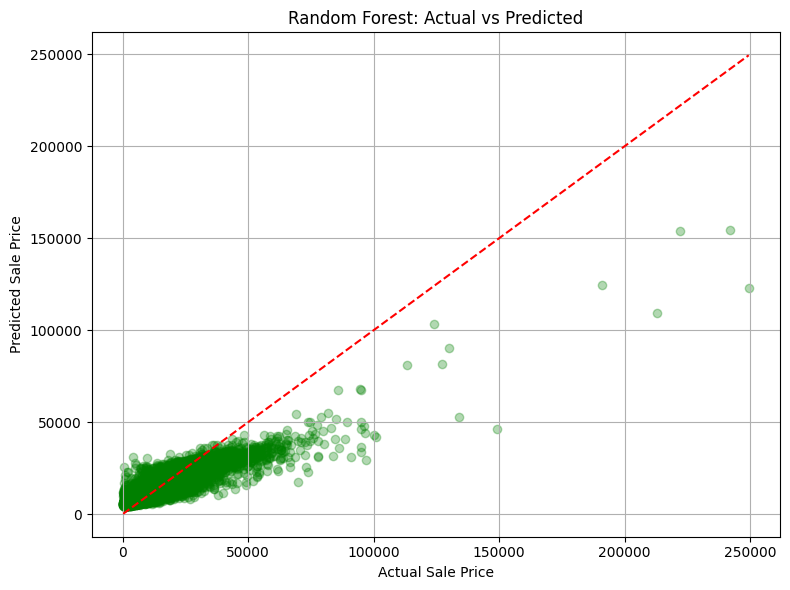

In [42]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.scatter(y_test, rf_predictions, alpha=0.3, color='green')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Sale Price')
plt.ylabel('Predicted Sale Price')
plt.title('Random Forest: Actual vs Predicted')
plt.grid(True)
plt.tight_layout()
plt.show()

XGBoost

In [43]:
from xgboost import XGBRegressor
import xgboost as xgb
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from bayes_opt import BayesianOptimization
from sklearn.metrics import r2_score

In [45]:
# def xgb_evaluate(max_depth, learning_rate, subsample, colsample_bytree, gamma, min_child_weight, reg_alpha, reg_lambda, n_jobs=-1):    
#     max_depth = int(max_depth)
#     min_child_weight = int(min_child_weight)

#     model = xgb.XGBRegressor(
#         objective='reg:squarederror',
#         eval_metric='rmse',
#         use_label_encoder=False,
#         random_state=0,
#         n_estimators=200,
#         max_depth=max_depth,
#         learning_rate=learning_rate,
#         subsample=subsample,
#         colsample_bytree=colsample_bytree,
#         gamma=gamma,
#         min_child_weight=min_child_weight,
#         reg_alpha=reg_alpha,
#         reg_lambda=reg_lambda,
#         n_jobs=n_jobs
# )
    
#     xgb_pipeline = Pipeline([
#         ('preproc', preprocessor),
#         ('xgb',     model)
#     ])

#     xgb_pipeline.fit(X_train, y_train)

#     y_pred = xgb_pipeline.predict(X_test)

#     return r2_score(y_test, y_pred)

# pbounds = {
#     'max_depth': (3, 10),                
#     'learning_rate': (0.01, 0.5),        
#     'subsample': (0.5, 1.0),             
#     'colsample_bytree': (0.5, 1.0),      
#     'gamma': (0, 5),                    
#     'min_child_weight': (1, 10),        
#     'reg_alpha': (0, 1),                
#     'reg_lambda': (0, 5)                
# }


# optimizer = BayesianOptimization(
#     f=xgb_evaluate,        
#     pbounds=pbounds,      
#     random_state=42,      
#     verbose=2              
# )

# optimizer.maximize(init_points=5, n_iter=A100)

# print('The best Hyperparameters:', optimizer.max['params'])
# print('The best Accuracy: {:.4f}'.format(optimizer.max['target']))


In [46]:
# import optuna
# from xgboost import XGBRegressor
# from sklearn.pipeline import Pipeline
# from sklearn.metrics import r2_score

# def objective(trial):
#     # 1) sample hyperparams
#     max_depth         = trial.suggest_int("max_depth", 3, 10)
#     learning_rate     = trial.suggest_float("learning_rate", 0.01, 0.5)
#     subsample         = trial.suggest_float("subsample", 0.5, 1.0)
#     colsample_bytree  = trial.suggest_float("colsample_bytree", 0.5, 1.0)
#     gamma             = trial.suggest_float("gamma", 0.0, 5.0)
#     min_child_weight  = trial.suggest_int("min_child_weight", 1, 10)
#     reg_alpha         = trial.suggest_float("reg_alpha", 0.0, 1.0)
#     reg_lambda         = trial.suggest_float("reg_lambda", 0.0, 5.0)
#     # n_jobs can stay fixed at -1, or you could expose it too

#     # 2) build model + pipeline
#     model = XGBRegressor(
#         objective='reg:squarederror',
#         eval_metric='rmse',
#         use_label_encoder=False,
#         random_state=0,
#         n_estimators=200,
#         max_depth=max_depth,
#         learning_rate=learning_rate,
#         subsample=subsample,
#         colsample_bytree=colsample_bytree,
#         gamma=gamma,
#         min_child_weight=min_child_weight,
#         reg_alpha=reg_alpha,
#         reg_lambda=reg_lambda,
#         n_jobs=-1
#     )
#     pipe = Pipeline([
#         ('preproc', preprocessor),
#         ('xgb',      model)
#     ])

#     pipe.fit(X_train, y_train)
#     y_pred = pipe.predict(X_test)

#     return r2_score(y_test, y_pred)

# # 4) create study & optimize
# study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler(seed=42))
# study.optimize(objective, n_trials=100, n_jobs=1)

# print("Best R²: {:.4f}".format(study.best_value))
# print("Best hyperparameters:")
# for k, v in study.best_params.items():
#     print(f"  {k}: {v}")

In [47]:
xgb_pipeline = Pipeline([
    ('preproc', preprocessor),
    ('xgb', XGBRegressor(
        # fixed hyperparameters from BayesOpt:
        max_depth=10,
        learning_rate=0.5,
        subsample=1.0,
        colsample_bytree=1.0,
        gamma=0.0,
        min_child_weight=5.6884070022627755,
        reg_alpha=0.0,
        reg_lambda=3.297797017784904,
        # keep the rest as before:
        objective='reg:squarederror',
        eval_metric='rmse',
        use_label_encoder=False,
        random_state=0,
        n_estimators=200,
        n_jobs=-1
    ))
])

kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(
    xgb_pipeline,
    X_train,
    y_train,
    cv=kf,
    scoring="r2",
    n_jobs=-1,
    verbose=1
)
print("5-Fold CV R² scores:", cv_scores)
print("Mean CV R²: {:.4f} ± {:.4f}".format(cv_scores.mean(), cv_scores.std()))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


5-Fold CV R² scores: [0.91426653 0.91210681 0.91489124 0.91109973 0.91368842]
Mean CV R²: 0.9132 ± 0.0014


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   54.2s finished


In [48]:
# 3. Fit & predict just like before
xgb_pipeline.fit(X_train, y_train)
xgb_predictions = xgb_pipeline.predict(X_test)
xgb_predictions_external = xgb_pipeline.predict(X_external)

In [49]:
xgb_r2 = r2_score(y_test, xgb_predictions)
xgb_mae = mean_absolute_error(y_test, xgb_predictions)
xgb_mse = mean_squared_error(y_test, xgb_predictions)
xgb_rmse = np.sqrt(xgb_mse)
xgb_mape = mean_absolute_percentage_error(y_test, xgb_predictions)

# Display results
print("📊 XGBoost Regression Evaluation Metrics")
print(f"R² Score  : {xgb_r2:.4f}")
print(f"MAE       : {xgb_mae:.2f}")
print(f"MSE       : {xgb_mse:.2f}")
print(f"RMSE      : {xgb_rmse:.2f}")
print(f"MAPE      : {xgb_mape:.2%}")

📊 XGBoost Regression Evaluation Metrics
R² Score  : 0.9211
MAE       : 2347.15
MSE       : 15031159.00
RMSE      : 3877.00
MAPE      : 36.85%


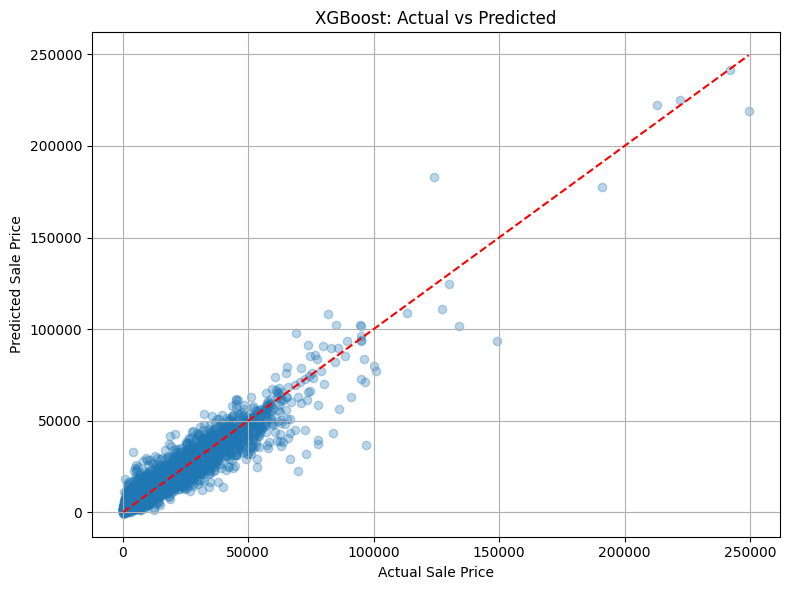

In [50]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.scatter(y_test, xgb_predictions, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Sale Price')
plt.ylabel('Predicted Sale Price')
plt.title('XGBoost: Actual vs Predicted')
plt.grid(True)
plt.tight_layout()
plt.show()

In [51]:
import shap
import matplotlib.pyplot as plt

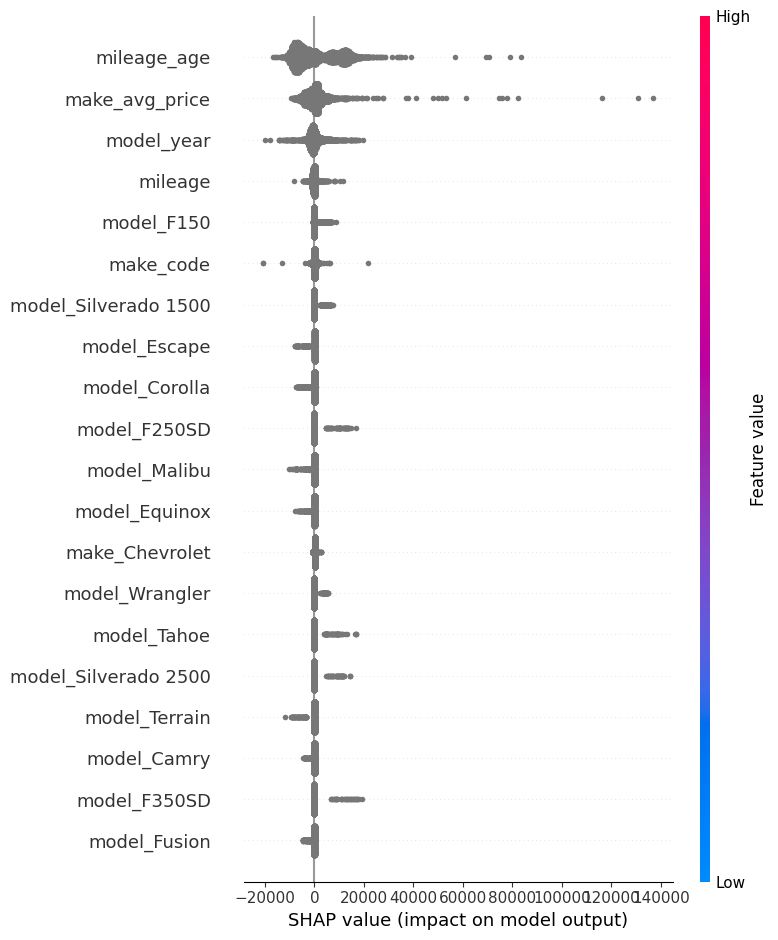

In [52]:
# 1) grab the fitted XGBRegressor
fitted_xgb = xgb_pipeline.named_steps['xgb']

# 2) transform your test set
X_test_trans = xgb_pipeline.named_steps['preproc'].transform(X_test)

# 3) use the tree explainer
explainer = shap.TreeExplainer(fitted_xgb)
shap_values = explainer.shap_values(X_test_trans)

# 4) plot, but you need feature names from the preprocessor
feature_names = numeric_feats + list(xgb_pipeline.named_steps['preproc']
                                    .named_transformers_['cat']
                                    .get_feature_names_out(categorical_feats))
shap.summary_plot(shap_values, X_test_trans, feature_names=feature_names)

In [53]:
import scipy.sparse as sp

# grab the first row of your transformed test set
first_row_sparse = X_test_trans[0]

# convert to a 1-D numpy array
if sp.issparse(first_row_sparse):
    first_row = first_row_sparse.toarray().flatten()
else:
    first_row = first_row_sparse

# now do the force plot
shap.initjs()
shap.force_plot(
    explainer.expected_value,
    shap_values[0],
    first_row,
    feature_names=feature_names
)

CatBoost

In [54]:
# from catboost import CatBoostRegressor
# from sklearn.pipeline import Pipeline
# from sklearn.metrics import r2_score
# from bayes_opt import BayesianOptimization

# def catb_evaluate(depth, learning_rate, subsample, rsm, l2_leaf_reg, n_jobs=-1):
#     # cast integer params
#     depth = int(depth)
#     l2_leaf_reg = max(1.0, l2_leaf_reg)  # ensure >0

#     model = CatBoostRegressor(
#         iterations=200,
#         depth=depth,
#         learning_rate=learning_rate,
#         subsample=subsample,         # requires bootstrap_type='Bernoulli'
#         rsm=rsm,                     # feature subsample fraction
#         l2_leaf_reg=l2_leaf_reg,     # L2 regularization
#         bootstrap_type='Bernoulli',
#         random_seed=0,
#         eval_metric='RMSE',
#         silent=True,
#         thread_count=n_jobs
#     )
    
#     catboost_pipeline = Pipeline([
#         ('preproc', preprocessor),
#         ('catb',    model)
#     ])
    
#     # fit & eval
#     catboost_pipeline.fit(X_train, y_train)
#     catboost_preds = catboost_pipeline.predict(X_test)
    
#     return r2_score(y_test, catboost_preds)


# # define search space (mapping subsample→bagging, rsm→colsample)
# pbounds = {
#     'depth':         (3, 10),
#     'learning_rate': (0.01, 0.3),
#     'subsample':     (0.5, 1.0),
#     'rsm':           (0.5, 1.0),
#     'l2_leaf_reg':   (1, 10),
# }

# optimizer = BayesianOptimization(
#     f=catb_evaluate,
#     pbounds=pbounds,
#     random_state=42,
#     verbose=2
# )

# optimizer.maximize(init_points=5, n_iter=100)

# print("Best params:", optimizer.max['params'])
# print("Best R²: {:.4f}".format(optimizer.max['target']))


In [55]:
from catboost import CatBoostRegressor
catboost_model = CatBoostRegressor(
    iterations= 300,
    learning_rate= 0.3,
    depth= int(10.0),
    subsample= 0.5,
    rsm= 1.0,
    l2_leaf_reg= 1.0,
    loss_function='RMSE',
    verbose=0,
    random_state=42
)


In [56]:
from sklearn.pipeline import Pipeline

catboost_pipeline = Pipeline([
    ('preproc', preprocessor),
    ('catboost', catboost_model)
])

In [57]:
# Fit the pipeline
catboost_pipeline.fit(X_train, y_train)

# Predict on test data
catboost_preds = catboost_pipeline.predict(X_test)
catboost_preds_external = catboost_pipeline.predict(X_external)

In [58]:
catboost_r2 = r2_score(y_test, catboost_preds)
catboost_mae = mean_absolute_error(y_test, catboost_preds)
catboost_mse = mean_squared_error(y_test, catboost_preds)
catboost_rmse = np.sqrt(catboost_mse)
catboost_mape = mean_absolute_percentage_error(y_test, catboost_preds)

# Display results
print("📊 catboost Regression Evaluation Metrics")
print(f"R² Score  : {catboost_r2:.4f}")
print(f"MAE       : {catboost_mae:.2f}")
print(f"MSE       : {catboost_mse:.2f}")
print(f"RMSE      : {catboost_rmse:.2f}")
print(f"MAPE      : {catboost_mape:.2%}")

📊 catboost Regression Evaluation Metrics
R² Score  : 0.9190
MAE       : 2413.82
MSE       : 15429571.46
RMSE      : 3928.05
MAPE      : 39.49%


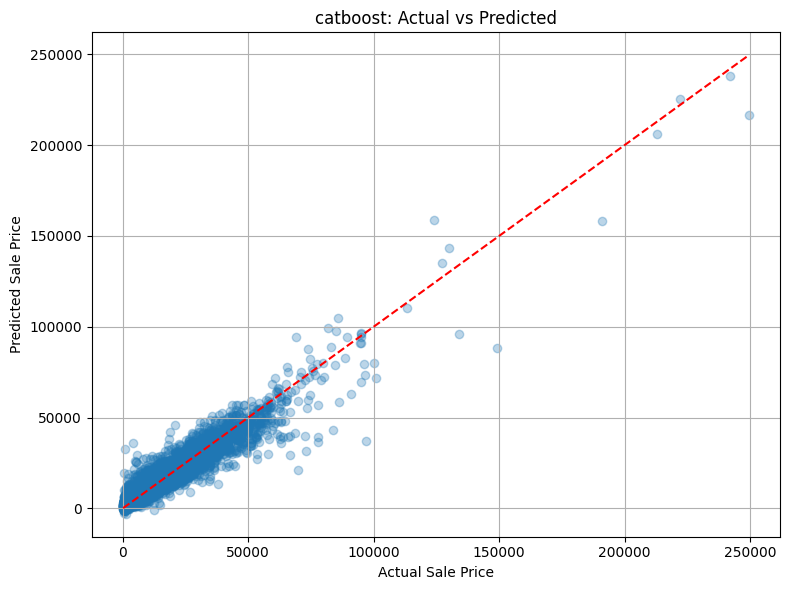

In [59]:
plt.figure(figsize=(8,6))
plt.scatter(y_test, catboost_preds, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Sale Price')
plt.ylabel('Predicted Sale Price')
plt.title('catboost: Actual vs Predicted')
plt.grid(True)
plt.tight_layout()
plt.show()

CatBoost Native Handling

In [60]:
from catboost import CatBoostRegressor, Pool
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

In [ ]:
# Define your categorical and numeric features
categorical_feats = [
    'make','model'
]
# …and add it into numeric_feats
numeric_feats = [
    'mileage','model_year','vehicle_age','mileage_per_year','drivable_flag','make_code','mileage_age','mileage_bucket','age_bucket'
]

# Combine for final feature set
all_feats = numeric_feats + categorical_feats


In [78]:
# Fill NaNs in categorical features with a string label (e.g., 'Unknown')
X_train[categorical_feats] = X_train[categorical_feats].fillna('Unknown')
X_test[categorical_feats] = X_test[categorical_feats].fillna('Unknown')

# Create CatBoost Pools to specify categorical columns
cat_features_indices = [X_train.columns.get_loc(col) for col in categorical_feats]

train_pool = Pool(X_train, y_train, cat_features=cat_features_indices)
test_pool = Pool(X_test, cat_features=cat_features_indices)

In [79]:
cat_model = CatBoostRegressor(
    iterations= 300,
    learning_rate= 0.01,
    depth= int(3.741102246131447),
    subsample= 0.6940881708873464,
    rsm= 0.6050881017968055,
    l2_leaf_reg= 6.164449857722794,
    loss_function='RMSE',
    verbose=0,
    random_state=42
)

cat_model.fit(train_pool)
cat_preds = cat_model.predict(test_pool)

In [80]:
cat_r2 = r2_score(y_test, cat_preds)
cat_mae = mean_absolute_error(y_test, cat_preds)
cat_mse = mean_squared_error(y_test, cat_preds)
cat_rmse = np.sqrt(cat_mse)
cat_mape = mean_absolute_percentage_error(y_test, cat_preds)

# Display results
print("📊 catboost Regression Evaluation Metrics")
print(f"R² Score  : {cat_r2:.4f}")
print(f"MAE       : {cat_mae:.2f}")
print(f"MSE       : {cat_mse:.2f}")
print(f"RMSE      : {cat_rmse:.2f}")
print(f"MAPE      : {cat_mape:.2%}")

📊 catboost Regression Evaluation Metrics
R² Score  : 0.7340
MAE       : 4209.21
MSE       : 50693051.17
RMSE      : 7119.91
MAPE      : 85.73%


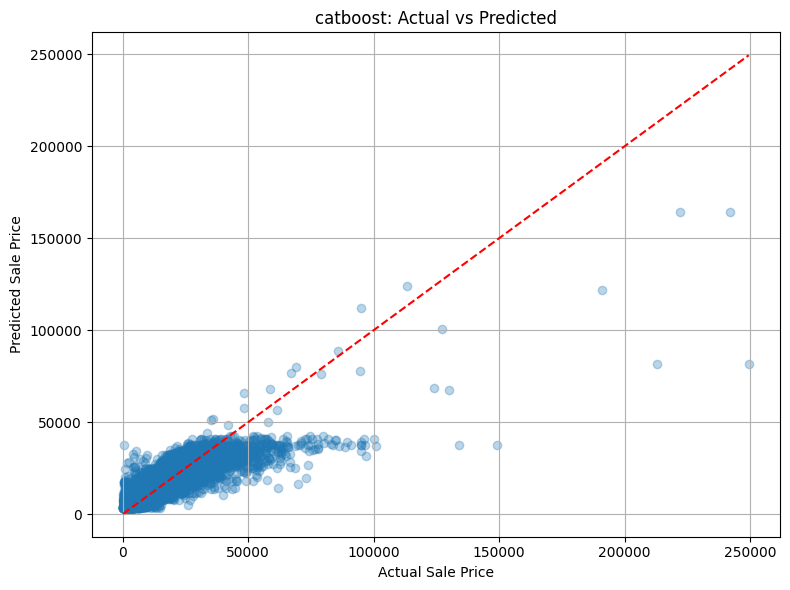

In [81]:
plt.figure(figsize=(8,6))
plt.scatter(y_test, cat_preds, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Sale Price')
plt.ylabel('Predicted Sale Price')
plt.title('catboost: Actual vs Predicted')
plt.grid(True)
plt.tight_layout()
plt.show()

Model Combination

In [66]:
import optuna
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.model_selection import cross_val_score

In [67]:
# Define the base models with fixed parameters
catboost_model = CatBoostRegressor(
    iterations= 300,
    learning_rate= 0.3,
    depth= int(10.0),
    subsample= 0.5,
    rsm= 1.0,
    l2_leaf_reg= 1.0,
    loss_function='RMSE',
    verbose=0,
    random_state=42
)

xgb_model =   XGBRegressor(
    # fixed hyperparameters from BayesOpt:
    max_depth=10,
    learning_rate=0.5,
    subsample=1.0,
    colsample_bytree=1.0,
    gamma=0.0,
    min_child_weight=5.6884070022627755,
    reg_alpha=0.0,
    reg_lambda=3.297797017784904,
    # keep the rest as before:
    objective='reg:squarederror',
    eval_metric='rmse',
    use_label_encoder=False,
    random_state=0,
    n_estimators=200,
    n_jobs=-1
)

In [68]:
# kf = KFold(n_splits=5, shuffle=True, random_state=42)

# def objective(trial):
#     meta_params = dict(
#         n_estimators     = trial.suggest_int('meta_n_estimators', 25, 300),
#         max_depth        = trial.suggest_int('meta_max_depth', 2, 8),
#         learning_rate    = trial.suggest_float('meta_learning_rate', 1e-3, 0.2, log=True),
#         subsample        = trial.suggest_float('meta_subsample', 0.5, 1.0),
#         colsample_bytree = trial.suggest_float('meta_colsample_bytree', 0.5, 1.0),
#         reg_alpha        = trial.suggest_float('meta_reg_alpha', 0.0, 5.0),
#         reg_lambda       = trial.suggest_float('meta_reg_lambda', 0.0, 10.0),
#         objective        = 'reg:squarederror',
#         eval_metric      = 'rmse',
#         random_state     = 42,
#         n_jobs           = -1
#     )

#     stack = StackingRegressor(
#         estimators=[('Cat', catboost_model), ('xgb', xgb_model)],
#         final_estimator=XGBRegressor(**meta_params),
#         passthrough=False,     # keep fixed unless you want to tune it too
#         n_jobs=-1              # sklearn >=1.4
#     )

#     pipe = Pipeline([
#         ('preproc', preprocessor),
#         ('stack',   stack)
#     ])

#     scores = cross_val_score(pipe, X_train, y_train,
#                              cv=kf, scoring='r2', n_jobs=-1)
#     return scores.mean()

# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=50, show_progress_bar=True)

# print("Best R²:", study.best_value)
# print("Best params:", study.best_params)

# # ---- Refit best model on full train ----
# best = study.best_params
# best_meta = XGBRegressor(
#     n_estimators     = best['meta_n_estimators'],
#     max_depth        = best['meta_max_depth'],
#     learning_rate    = best['meta_learning_rate'],
#     subsample        = best['meta_subsample'],
#     colsample_bytree = best['meta_colsample_bytree'],
#     reg_alpha        = best['meta_reg_alpha'],
#     reg_lambda       = best['meta_reg_lambda'],
#     objective        = 'reg:squarederror',
#     eval_metric      = 'rmse',
#     random_state     = 42,
#     n_jobs           = -1
# )

# final_stack = StackingRegressor(
#     estimators=[('Cat', catboost_model), ('xgb', xgb_model)],
#     final_estimator=best_meta,
#     passthrough=False,
#     n_jobs=-1
# )

# final_pipeline = Pipeline([
#     ('preproc', preprocessor),
#     ('stack',   final_stack)
# ]).fit(X_train, y_train)

# y_pred = final_pipeline.predict(X_test)

In [69]:
# 3) Build the stacking regressor
stack = StackingRegressor(
    estimators=[
        ('Cat',  catboost_model),
        ('xgb', xgb_model)
    ],
    final_estimator=XGBRegressor(
        n_estimators=50,
        learning_rate=0.1,
        random_state=42
    ),
    # passthrough=True  # if you want the original features concatenated to meta‑features
)

# 4) Put it all in one pipeline
stacking_pipeline = Pipeline([
    ('preproc', preprocessor),
    ('stack',   stack)
])

# 5) Fit & evaluate
stacking_pipeline.fit(X_train, y_train)
y_pred = stacking_pipeline.predict(X_test)
y_pred_external = stacking_pipeline.predict(X_external)

#print("Stacked R²:", r2_score(y_test, y_pred))

In [70]:
y_r2 = r2_score(y_test, y_pred)
y_mae = mean_absolute_error(y_test, y_pred)
y_mse = mean_squared_error(y_test, y_pred)
y_rmse = np.sqrt(y_mse)
y_mape = mean_absolute_percentage_error(y_test, y_pred)

# Display results
print("📊 stack Regression Evaluation Metrics")
print(f"R² Score  : {y_r2:.4f}")
print(f"MAE       : {y_mae:.2f}")
print(f"MSE       : {y_mse:.2f}")
print(f"RMSE      : {y_rmse:.2f}")
print(f"MAPE      : {y_mape:.2%}")

📊 stack Regression Evaluation Metrics
R² Score  : 0.8807
MAE       : 2434.22
MSE       : 22735788.00
RMSE      : 4768.21
MAPE      : 37.73%


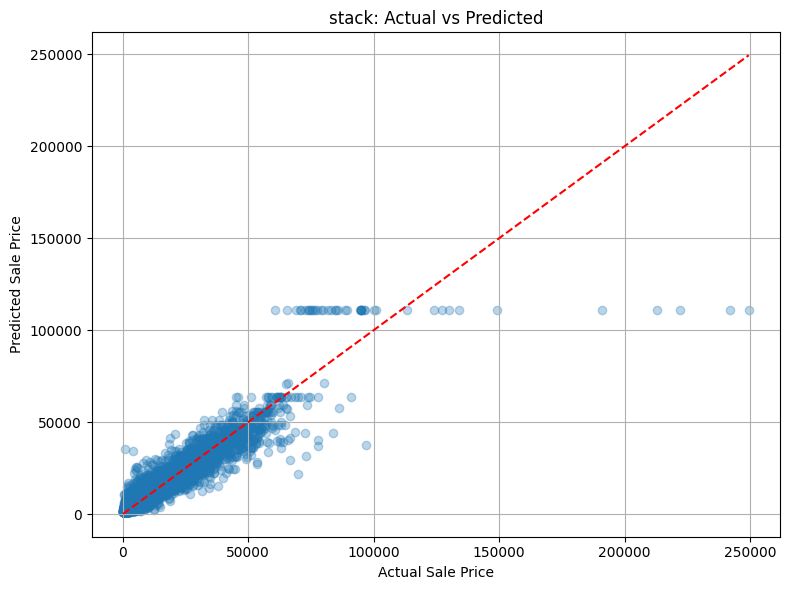

In [71]:
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Sale Price')
plt.ylabel('Predicted Sale Price')
plt.title('stack: Actual vs Predicted')
plt.grid(True)
plt.tight_layout()
plt.show()

Visualize the actual prices and Predicted prices

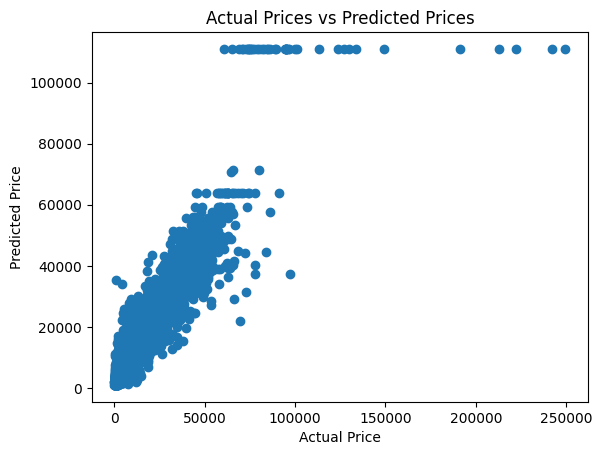

In [72]:
plt.scatter(y_test, y_pred)
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Actual Prices vs Predicted Prices")
plt.show()

Final Model Evaluation

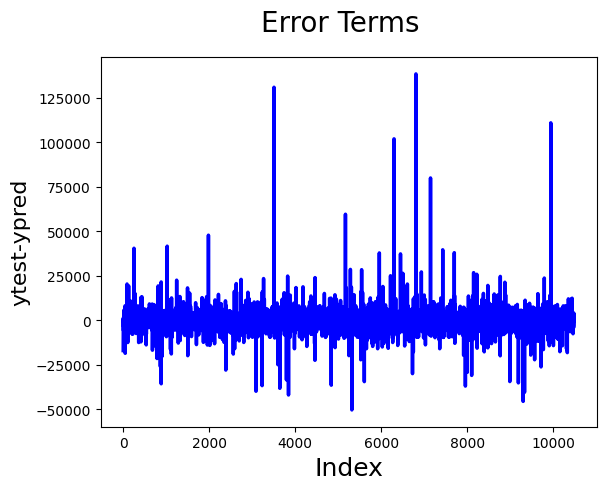

In [73]:
# Error terms
c = [i for i in range(len(y_pred))]
fig = plt.figure()
plt.plot(c,y_test-y_pred, color="blue", linewidth=2.5, linestyle="-")
fig.suptitle('Error Terms', fontsize=20)              # Plot heading 
plt.xlabel('Index', fontsize=18)                      # X-label
plt.ylabel('ytest-ypred', fontsize=16)                # Y-label
plt.show()

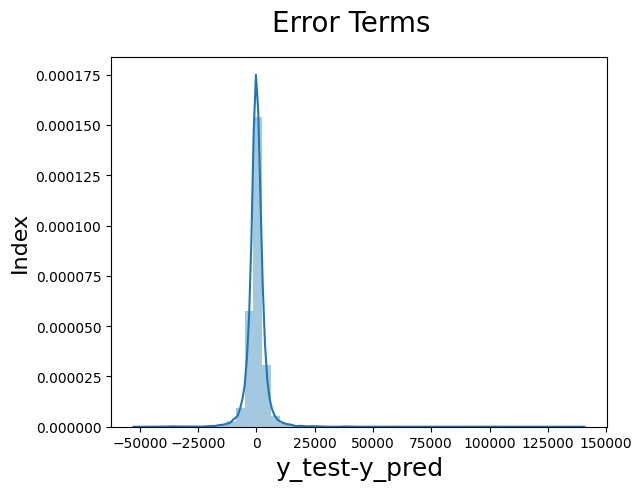

In [74]:
# Plotting the error terms to understand the distribution.
fig = plt.figure()
sns.distplot((y_test-y_pred),bins=50)
fig.suptitle('Error Terms', fontsize=20)                  # Plot heading 
plt.xlabel('y_test-y_pred', fontsize=18)                  # X-label
plt.ylabel('Index', fontsize=16)                          # Y-label
plt.show()

Export the Predictions

In [75]:
# 1) Extract the true y values for X_external
y_external = cars_test['gross_sale_price']

# 2) Compute R² for each model
r2_xgb      = r2_score(y_external, xgb_predictions_external)
r2_catboost = r2_score(y_external, catboost_preds_external)
r2_stack    = r2_score(y_external, y_pred_external)

# 3) Print results
print(f"XGBoost external R²:      {r2_xgb:.4f}")
print(f"CatBoost external R²:     {r2_catboost:.4f}")
print(f"Stacked model external R²:{r2_stack:.4f}")

XGBoost external R²:      0.2542
CatBoost external R²:     0.2637
Stacked model external R²:0.2598


In [82]:
# # Create a DataFrame with the original prices and the predicted sales prices
# result_df = pd.DataFrame({
#     'SoldPrice': y_test,  # Original prices from y_test
#     'XGB_Predictions': xgb_predictions,
#     'RF_Predictions': rf_predictions,
#     'Stacked_Predictions': y_pred
# })

result_df = pd.DataFrame({
    'XGB_Predictions': xgb_predictions_external,
    'CatBoost_Predictions': catboost_preds_external,
    'Stacked_Predictions': y_pred_external
})

final_df = pd.concat([cars_test_original.reset_index(drop=True), result_df.reset_index(drop=True)], axis=1)

# Export the DataFrame to a CSV file
final_df.to_excel('NAAA Test.xlsx', index=False)